# Gaussian XOR and Gaussian R-XOR Experiment

One key goal of omnidirectional learning is to be able to continually improve upon past performance with the introduction of new data, without forgetting too much of the past tasks. This transfer of information can be evaluated using a variety of metrics; however, here, we use a generalization of Pearl's transfer-benefit ratio (TBR) in both the forward and backward directions.

As described in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf), the forward transfer efficiency of task $f_n$ for task $t$ given $n$ samples is:

$$FTE^t (f_n) := \mathbb{E} [R^t (f^{t}_n )/R^t (f^{<t}_n )]$$

If $FTE^t(f_n)>1$, the algorithm demonstrates positive forward transfer, i.e. past task data has been used to improve performance on the current task.

Similarly, the backward transfer efficiency of task $f_n$ for task $t$ given $n$ samples is:

$$BTE^t (f_n) := \mathbb{E} [R^t (f_n^{<t} )/R^t (f_n)]$$

If $BTE^t(f_n)>1$, the algorithm demonstrates positive backward transfer, i.e. data from the current task has been used to improve performance on past tasks.

Omnidirectional learning in a simple environment can therefore be demonstrated using two simple tasks: Gaussian XOR and Gaussian R-XOR. Here, forward transfer efficiency is the ratio of generalization errors for R-XOR, whereas backward transfer efficiency is the ratio of generalization errors for XOR. These two tasks share the same discriminant boundaries, so learning can be easily transferred between them.

This experiment compares the performance of omnidirectional forests to uncertainty forests in undergoing these tasks.

In [1]:
import numpy as np

import functions.xor_rxor_functions as fn
from proglearn.sims import generate_gaussian_parity

**Note:** This notebook tutorial uses functions stored externally within `functions/xor_rxor_functions.py`, to simplify presentation of code. These functions are imported above, along with other libraries.

## Classification Problem

First, let's visualize Gaussian XOR and R-XOR.

Gaussian XOR is a two-class classification problem, where...
- Class 0 is drawn from two Gaussians with $\mu = \pm [0.5, 0.5]^T$ and $\sigma^2 = 0.25I$.
- Class 1 is drawn from two Gaussians with $\mu = \pm [0.5, -0.5]^T$ and $\sigma^2 = 0.25I$.

Gaussian R-XOR has the same distribution as Gaussian XOR, but with the class labels at a 45 degree angle

Within the proglearn package, we can make use of the simulations within the `sims` folder to generate simulated data. The `generate_gaussian_parity` function within `gaussian_sim.py` can be used to create the Gaussian XOR and R-XOR problems. Let's generate data and plot it to see what these problems look like!

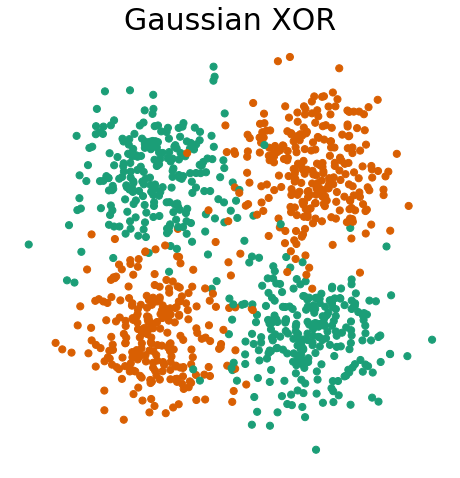

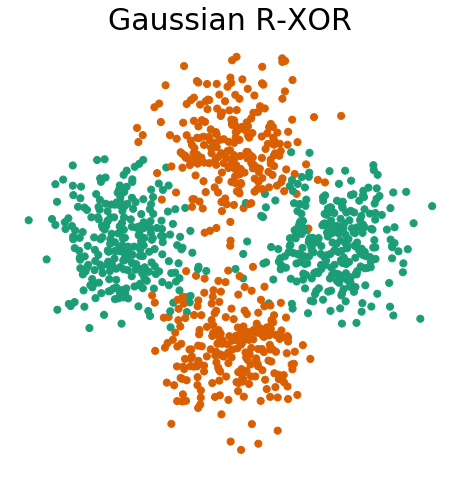

In [2]:
# call function to return gaussian xor and rxor data:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi / 4)

# plot and format:
fn.plot_xor_rxor(X_xor, y_xor, "Gaussian XOR")
fn.plot_xor_rxor(X_rxor, y_rxor, "Gaussian R-XOR")

## The Experiment

Now that we have generated the data, we can prepare to run the experiment. The function for running the experiment, `experiment`, can be found within `functions/xor_rxor_functions.py`.

We first declare the hyperparameters to be used for the experiment, which are as follows:
- `mc_rep`: number of repetitions to run the omnidirectional learning algorithm for
- `n_test`: number of xor/rxor data points in the test set
- `n_trees`: number of trees
- `n_xor`: array containing number of xor data points fed to learner, ranges from 50 to 725 in increments of 25
- `n_rxor`: array containing number of rxor data points fed to learner, ranges from 50 to 750 in increments of 25

In [3]:
# define hyperparameters:
mc_rep = 1000
n_test = 1000
n_trees = 10
n_xor = (100 * np.arange(0.5, 7.50, step=0.25)).astype(int)
n_rxor = (100 * np.arange(0.25, 7.50, step=0.25)).astype(int)

Once those are determined, the experiment can be initialized and performed. We iterate over the values in `n_xor` and `n_rxor` sequentially, running each experiment for the number of iterations declared in `mc_rep`.

In [4]:
# running the experiment:

# create empty arrays for storing results
mean_error = np.zeros((6, len(n_xor) + len(n_rxor)))
std_error = np.zeros((6, len(n_xor) + len(n_rxor)))
mean_te = np.zeros((4, len(n_xor) + len(n_rxor)))
std_te = np.zeros((4, len(n_xor) + len(n_rxor)))

# run the experiment
mean_error, std_error, mean_te, std_te = fn.run(
    mc_rep, n_test, n_trees, n_xor, n_rxor, mean_error, std_error, mean_te, std_te
)

Great! The experiment should now be complete, with the results stored in four arrays: `mean_error`, `std_error`, `mean_te`, and `std_te`.

## Visualizing the Results

Now that the experiment is complete, the results can be visualized by extracting the data from these arrays and plotting it. 

Here, we again utilize functions from `functions/xor_rxor_functions.py` to help in plotting:
- `plot_error-and-eff`: plots generalization error and transfer efficiency for omnidirectional and random forests

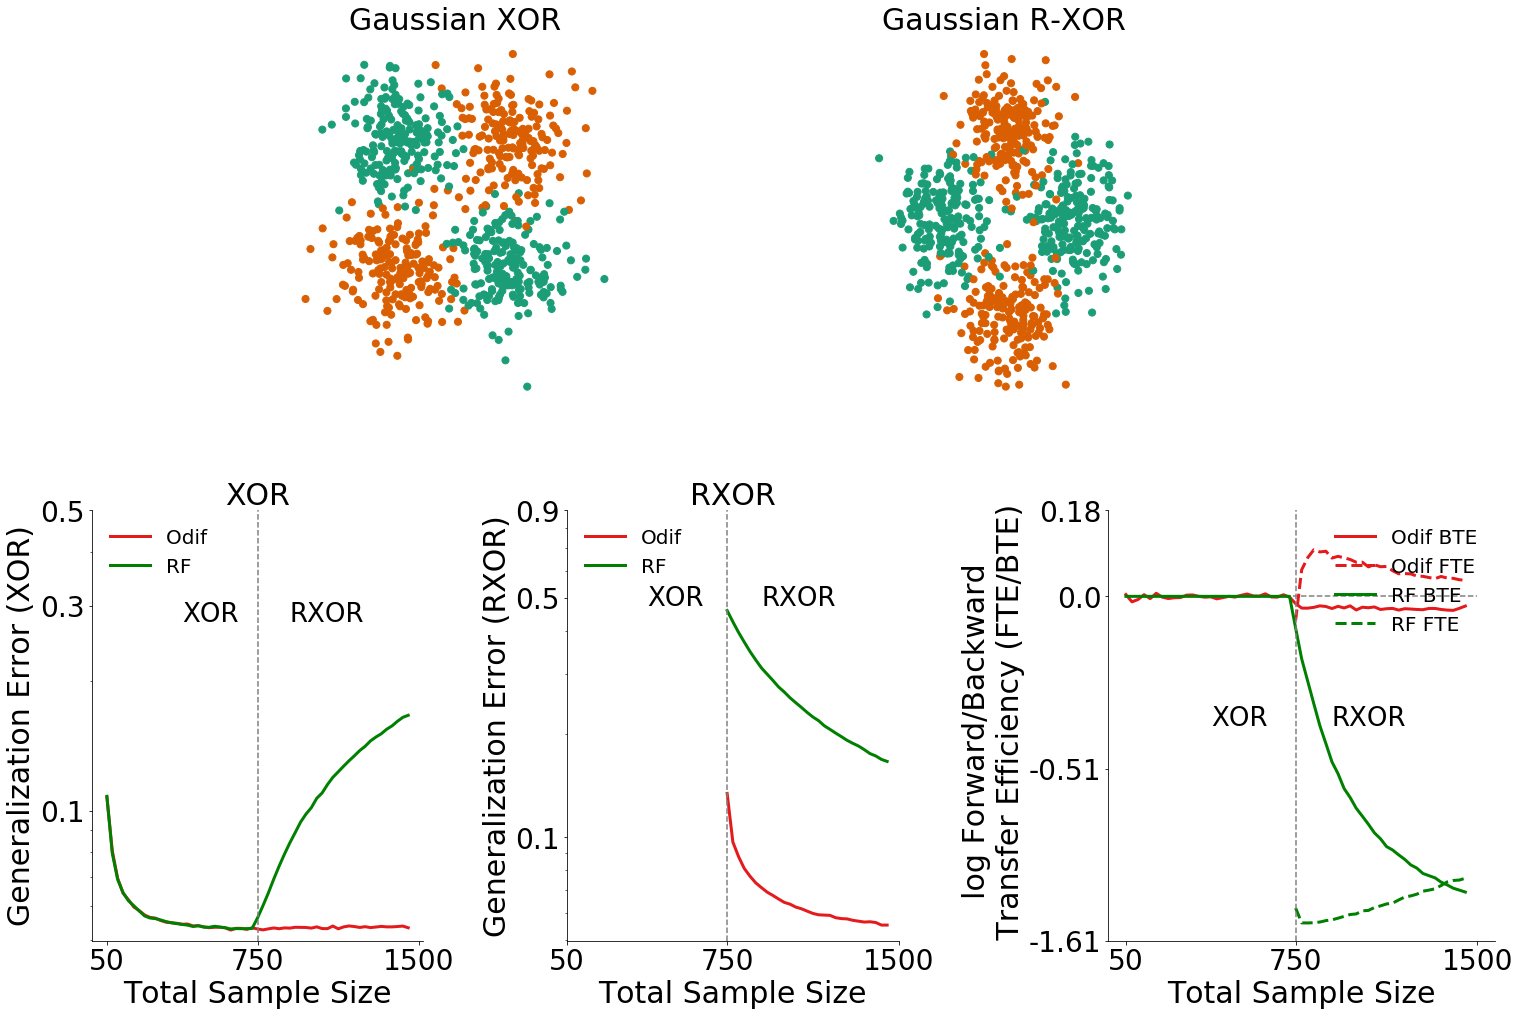

In [5]:
# plot data
%matplotlib inline
fn.plot_error_and_eff(n_xor, n_rxor, mean_error, mean_te, "XOR", "RXOR")

#### Generalization Error for XOR Data (bottom left plot)

By plotting the generalization error for XOR data, we can see how the 
introduction of RXOR data influenced the performance of both the omnidirectional learning forest and the random forest. 

In the bottom left plot, we see that when RXOR data is available, the omnidirectional learning forest outperforms random forests.

#### Generalization Error for RXOR Data (bottom middle plot)

Similarly, by plotting the generalization error for RXOR data, we can also see how the presence of XOR data influenced the performance of both algorithms. 

In the bottom middle plot, we see that given XOR data is available, the omnidirectional learning forest outperforms random forests on classifying RXOR data.

#### Transfer Efficiency for XOR Data (bottom right plot)

Given the generalization errors plotted above, we can find the transfer efficiency as a ratio of the generalization error for omnidirectinal learning to random forests. The forward and backward transfer efficiencies are then plotted in the bottom right plot.

Omnidirectional learning forests demonstrate both positive forward and backward transfer in this environment

## Various Angles vs BTE

First, we'll set the variables we'll use:
- `mc_rep`: number of repetitions to run the omnidirectional learning algorithm for
- `angle_sweep`: angles to test
- `task1_sample`: number of task 1 samples
- `task2_sample`: number of task 2 samples

In [6]:
angle_sweep = range(0, 90, 1)
task1_sample = 100
task2_sample = 100
mc_rep = 10000  # reduce the number of repetitions for reduced runtime

Next, we'll run the experiment:

In [7]:
mean_te = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep)

Lastly, plot the results:

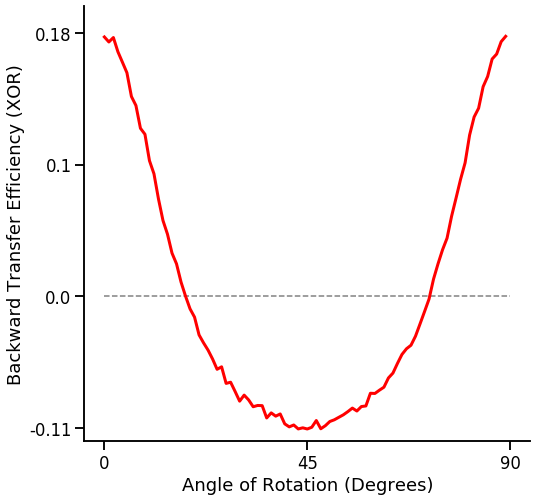

In [8]:
fn.plot_bte_v_angle(mean_te)

## Number of training samples vs BTE

First, we'll set the variables we'll use:
- `mc_rep`: number of repetitions to run the omnidirectional learning algorithm for
- `task2_sample_sweep`: list of the number of samples to test
- `task1_sample`: number of task 1 samples
- `task2_angle`: fixed angle of the task 2 data

In [9]:
task2_sample_sweep = (2 ** np.arange(np.log2(60), np.log2(5010) + 1, 0.25)).astype(
    "int"
)
task1_sample = [100, 1000, 5000]
task2_angle = 25 * np.pi / 180
mc_rep = 1000

Next, run the experiment:

In [10]:
mean_te = fn.bte_v_nsamples(task2_sample_sweep, task1_sample, task2_angle, mc_rep)

Lastly, plot the results:

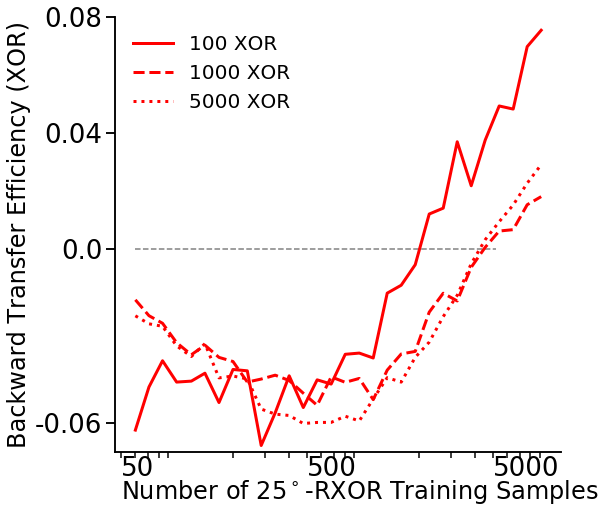

In [16]:
fn.plot_bte_v_nsamples(mean_te)